In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/nlp/tweet_emotion_classification')

In [31]:
!pwd

/content/drive/MyDrive/Colab Notebooks/nlp/tweet_emotion_classification


## 데이터셋

In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.0 MB/s eta 0:00:00


### 데이터 불러오기

In [7]:
from datasets import load_dataset
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
data = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [10]:
data_train = data['train']
data_train[:3]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong'],
 'label': [0, 0, 3]}

In [11]:
data_val = data['validation']
data_test = data['test']

In [12]:
lebel_features = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

In [13]:
def label_int_to_text(row):
    temp = []
    for i in row:
        temp.append(lebel_features[i])
    return temp

In [14]:
data.set_format(type='pandas')
df_train = data['train'][:]
df_train['lable_name'] = label_int_to_text(df_train['label'])
df_train.head()

,text,label,lable_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Label 분포 살펴보기

In [15]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

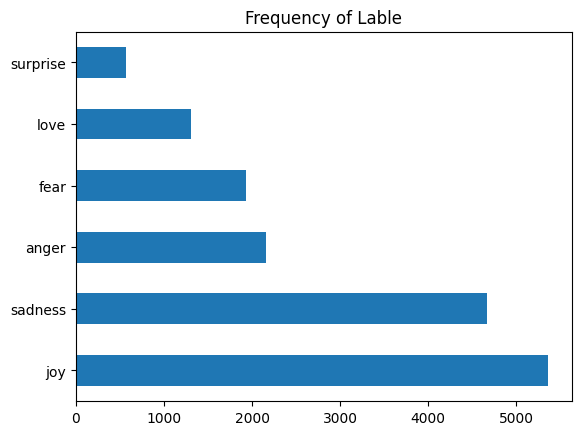

In [16]:
df_train['lable_name'].value_counts().plot.barh()
plt.title('Frequency of Lable')
plt.show

### 문장 길이 확인

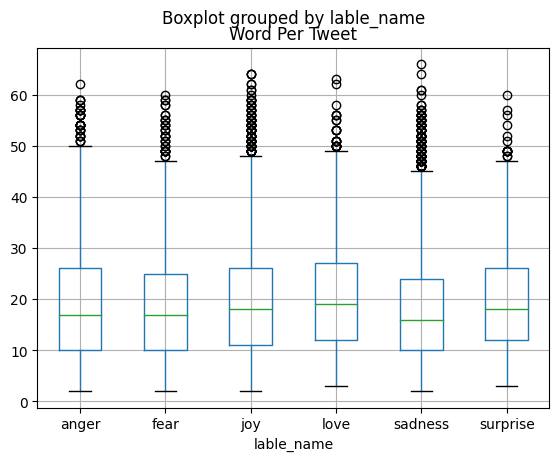

In [17]:
df_train["Word Per Tweet"] = df_train['text'].str.split().apply(len)
df_train.boxplot("Word Per Tweet",by="lable_name")
plt.show()

In [18]:
max_len = 0
for i in df_train['text']:
    max_len = max(max_len, len(i))
max_len

300

In [19]:
data.reset_format()

### RNN

Tokenizer

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical

In [21]:
tokenizer = Tokenizer()
train = data_train['text']
tokenizer.fit_on_texts(data_train['text'])
train_encoded = tokenizer.texts_to_sequences(train)
train_padded = pad_sequences(train_encoded, maxlen = max_len)
print(train_encoded[:3])
print(train_padded.shape)

[[1, 138, 2, 678], [1, 39, 100, 59, 7, 14, 493, 4, 14, 3495, 552, 31, 59, 60, 127, 147, 75, 1479, 3, 21, 1254], [16, 3059, 6, 1148, 4, 285, 1, 2, 494, 437]]
(16000, 300)


In [22]:
train_y = to_categorical(data_train['label'])
train_y

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [23]:
val = data_val['text']
val_encoded = tokenizer.texts_to_sequences(val)
val_padded = pad_sequences(val_encoded, maxlen = max_len)
val_y = to_categorical(data_val['label'])

print(val_encoded[:3])
print(val_padded.shape)
print(val_y)

[[16, 7, 156, 259, 3, 342, 15, 50, 18, 211, 11288, 49, 9, 12, 532], [1, 2, 13, 1, 23, 71, 252, 32, 6, 617, 2742, 617, 1417, 9, 1103], [1, 2, 13, 6, 613]]
(2000, 300)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [24]:
test = data_test['text']
test_encoded = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_encoded, maxlen = max_len)
test_y = to_categorical(data_test['label'])

print(test_encoded[:3])
print(test_padded.shape)
print(test_y)

[[16, 7, 202, 714, 14, 16, 25, 45, 5594, 113, 57], [16, 12799, 10, 242, 36, 1, 2, 468], [1, 144, 79, 67, 2970, 59, 17, 36, 1, 103, 42, 164, 66, 67, 4, 2, 13, 1, 92, 405, 24, 67]]
(2000, 300)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [25]:
total_cnt = len(tokenizer.word_index)
total_cnt

15212

RNN model

In [32]:
import tensorflow
from keras.layers import SimpleRNN, Embedding, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 32
hidden_units = 32
vocab_size = total_cnt+1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(6, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('rnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(train_padded, train_y, batch_size=32, epochs=10, callbacks=[es, mc], validation_data=(val_padded, val_y))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.4497 - acc: 0.4449
Epoch 1: val_acc improved from -inf to 0.60450, saving model to rnn_best_model.h5
500/500 [==============================] - 40s 78ms/step - loss: 1.4497 - acc: 0.4449 - val_loss: 1.1668 - val_acc: 0.6045
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.7973 - acc: 0.7309
Epoch 2: val_acc improved from 0.60450 to 0.77350, saving model to rnn_best_model.h5
500/500 [==============================] - 36s 73ms/step - loss: 0.7973 - acc: 0.7309 - val_loss: 0.6770 - val_acc: 0.7735
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.4659 - acc: 0.8482
Epoch 3: val_acc improved from 0.77350 to 0.82650, saving model to rnn_best_model.h5
500/500 [==============================] - 39s 78ms/step - loss: 0.4659 - acc: 0.8482 - val_loss: 0.5660 - val_acc: 0.8265
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.2688 - acc: 0.9171
Epoch 4: val_ac

평가

In [33]:
from keras.models import load_model

In [34]:
loaded_model = load_model('rnn_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_padded, test_y)[1]))

63/63 [==============================] - 1s 15ms/step - loss: 0.5620 - acc: 0.8295

 테스트 정확도: 0.8295


### LSTM

LSTM model

In [35]:
from keras.layers import LSTM, Embedding, Dense

embedding_dim = 32
hidden_units = 32
vocab_size = total_cnt+1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(6, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(train_padded, train_y, batch_size=32, epochs=10, callbacks=[es, mc], validation_data=(val_padded, val_y))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.3347 - acc: 0.4840
Epoch 1: val_acc improved from -inf to 0.69850, saving model to lstm_best_model.h5
500/500 [==============================] - 62s 119ms/step - loss: 1.3347 - acc: 0.4840 - val_loss: 0.8476 - val_acc: 0.6985
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.5650 - acc: 0.8135
Epoch 2: val_acc improved from 0.69850 to 0.81150, saving model to lstm_best_model.h5
500/500 [==============================] - 58s 117ms/step - loss: 0.5650 - acc: 0.8135 - val_loss: 0.5301 - val_acc: 0.8115
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.2795 - acc: 0.9126
Epoch 3: val_acc improved from 0.81150 to 0.88700, saving model to lstm_best_model.h5
500/500 [==============================] - 58s 117ms/step - loss: 0.2795 - acc: 0.9126 - val_loss: 0.3596 - val_acc: 0.8870
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.1632 - acc: 0.9507
Epoch 4: 

평가

In [36]:
loaded_model = load_model('lstm_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_padded, test_y)[1]))

63/63 [==============================] - 2s 28ms/step - loss: 0.3451 - acc: 0.8925

 테스트 정확도: 0.8925


### CNN

CNN model

In [37]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, Dense

embedding_dim = 32
hidden_units = 32
vocab_size = total_cnt+1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(6, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(train_padded, train_y, batch_size=32, epochs=10, callbacks=[es, mc], validation_data=(val_padded, val_y))

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.0273 - acc: 0.6216
Epoch 1: val_acc improved from -inf to 0.92050, saving model to cnn_best_model.h5
500/500 [==============================] - 26s 49ms/step - loss: 1.0273 - acc: 0.6216 - val_loss: 0.2725 - val_acc: 0.9205
Epoch 2/10
499/500 [============================>.] - ETA: 0s - loss: 0.1695 - acc: 0.9329
Epoch 2: val_acc improved from 0.92050 to 0.92100, saving model to cnn_best_model.h5
500/500 [==============================] - 23s 46ms/step - loss: 0.1693 - acc: 0.9329 - val_loss: 0.1627 - val_acc: 0.9210
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.0969 - acc: 0.9583
Epoch 3: val_acc improved from 0.92100 to 0.92600, saving model to cnn_best_model.h5
500/500 [==============================] - 25s 50ms/step - loss: 0.0969 - acc: 0.9583 - val_loss: 0.1706 - val_acc: 0.9260
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.0657 - acc: 0.9746
Epoch 4: val_ac

In [38]:
loaded_model = load_model('cnn_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_padded, test_y)[1]))

63/63 [==============================] - 1s 10ms/step - loss: 0.1600 - acc: 0.9235

 테스트 정확도: 0.9235
